# 37.3 Final Capstone

In [196]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import itertools

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as grid_spec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go


# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from gensim.models import Word2Vec

# Supervised ML
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Unsupervised ML
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# Decomp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

sns.set_style('dark')
plt.style.use('dark_background')
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'sans-serif']

pd.options.display.float_format = '{:,.2f}'.format

%config InlineBackend.figure_format = 'retina'



In [2]:
whisky = pd.read_csv('whisky1.csv', skiprows=0, index_col=0, 
                     dtype= {'year':'Int64','age':'Int64', 'vintage':'Int64'} )

In [3]:
whisky.info()
whisky.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5208 entries, 0 to 5207
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       5208 non-null   int64  
 1   label        5208 non-null   object 
 2   subcategory  5208 non-null   object 
 3   category     5208 non-null   object 
 4   review       5208 non-null   object 
 5   reviewer     5208 non-null   object 
 6   year         5208 non-null   Int64  
 7   abv          5182 non-null   float64
 8   price        5208 non-null   float64
 9   age          1954 non-null   Int64  
 10  vintage      1164 non-null   Int64  
dtypes: Int64(3), float64(2), int64(1), object(5)
memory usage: 503.5+ KB


rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  
0 40.50  4,500.00    42     1964  
1 42.90 13,500.00    46     1964  
2 40.00    225.00  <NA>     <NA>  
3 50.80    750.00  <NA>     1969  
4 45.40  1,500.00    29     1976

In [4]:
whisky.iloc[3702]

rating                                                        86
label          Buffalo Trace Experimental Collection Wheat 10...
subcategory                                    Bourbon/Tennessee
category                                                American
review         Drier on the palate than the 90, with more car...
reviewer                                            John Hansell
year                                                        2013
abv                                                        45.00
price                                                      47.00
age                                                         <NA>
vintage                                                     <NA>
Name: 3702, dtype: object

In [5]:
whisky.reviewer.unique()

array(['John Hansell', 'Dave Broom', 'Jonny McCormick', 'Dominic Roskrow',
       'Gavin Smith', 'Geoffrey Kleinman', 'Susannah Skiver Barton',
       'David Fleming', 'Adam Polonski', 'Fred Minnick',
       'Jeffery Lindenmuth', 'Davin de Kergommeaux', 'Lew Bryson'],
      dtype=object)

In [6]:
# graphs to look at:
# Bar graph for category / count
# histogram of rating, abv, price
# correlation plots = rating/price, age/price, age/rating
# bar graph of reviewers / count
# after NLP, word clouds

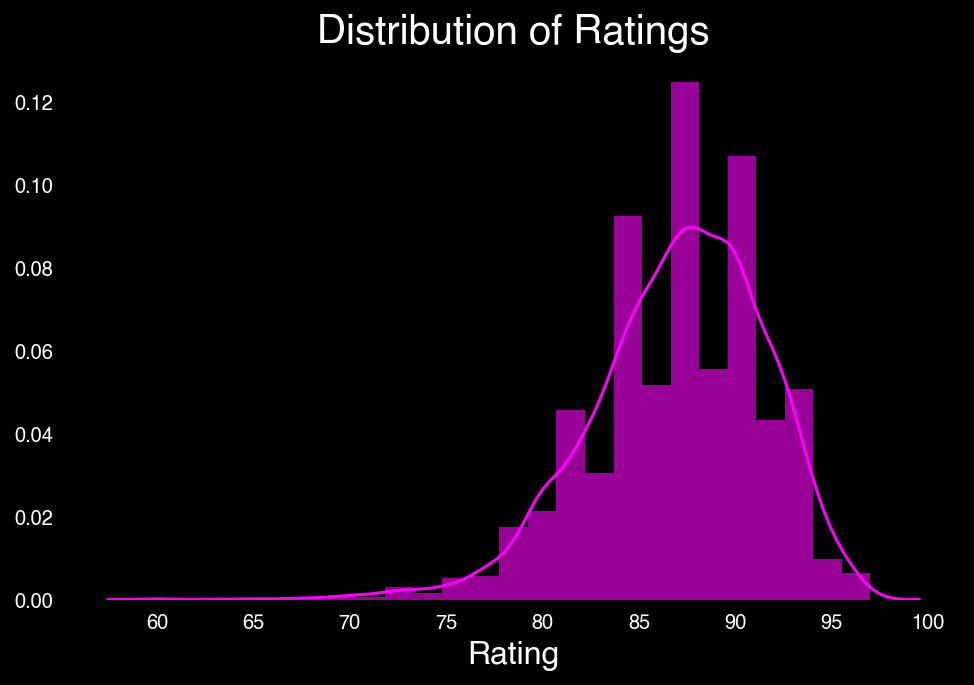

In [7]:
# plotting ratings distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(whisky.rating, bins=25, color='magenta', ax=ax, hist_kws={'linewidth':0, 'alpha':.6})
ax.set_title('Distribution of Ratings', fontsize=20)
ax.set_xticks(np.arange(60,101,5))
ax.set_xlabel('Rating', fontsize=16);

for i in ['top','right','left', 'bottom']:
    ax.spines[i].set_visible(False)

In [8]:
print(whisky.rating.max())
print(whisky.rating.min())

97
60


In [9]:
whisky[whisky.rating==60]

rating                                              label  \
4339      60                                       Cavalry, 45%   
4340      60  Woodford Reserve Master’s Collection Five Malt...   

                   subcategory  category  \
4339         Bourbon/Tennessee  American   
4340  Blended American Whiskey  American   

                                                 review      reviewer  year  \
4339  Although it’s not on the label, Cavalry uses t...  Fred Minnick  2016   
4340  Four barley types—two row, pale chocolate, kil...  Fred Minnick  2016   

       abv  price   age  vintage  
4339 45.00  30.00  <NA>     <NA>  
4340 45.20  50.00  <NA>     <NA>

In [10]:
print(sorted(whisky.year.unique()))
# 1992 is the odd one out and we aren't completely through 2020, so we'll filter those out in the year analysis

[1992, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


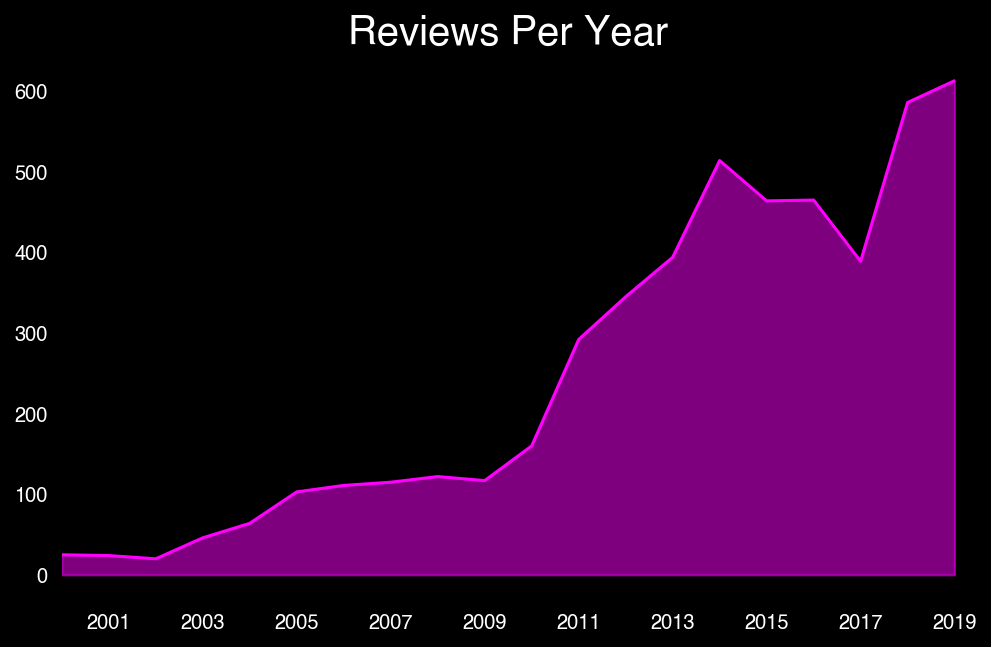

In [11]:
# number of reviews per year
years_filtered = whisky[(whisky.year < 2020)&(whisky.year>1992)]
reviews_by_year = years_filtered[['review','year']].groupby('year').count()

fig, ax = plt.subplots(figsize=(8,5))

reviews_by_year.plot(color='magenta', legend=False, ax=ax)
ax.fill_between(np.arange(2000,2020), reviews_by_year.review, color='magenta', alpha=.5)
ax.set(xlim=(2000,2019), xticks=[2001,2003,2005,2007,2009,2011,2013,2015,2017,2019], xlabel='')
ax.set_title('Reviews Per Year', fontsize=20)

for i in ['top','bottom','right','left']:
    ax.spines[i].set_visible(False)

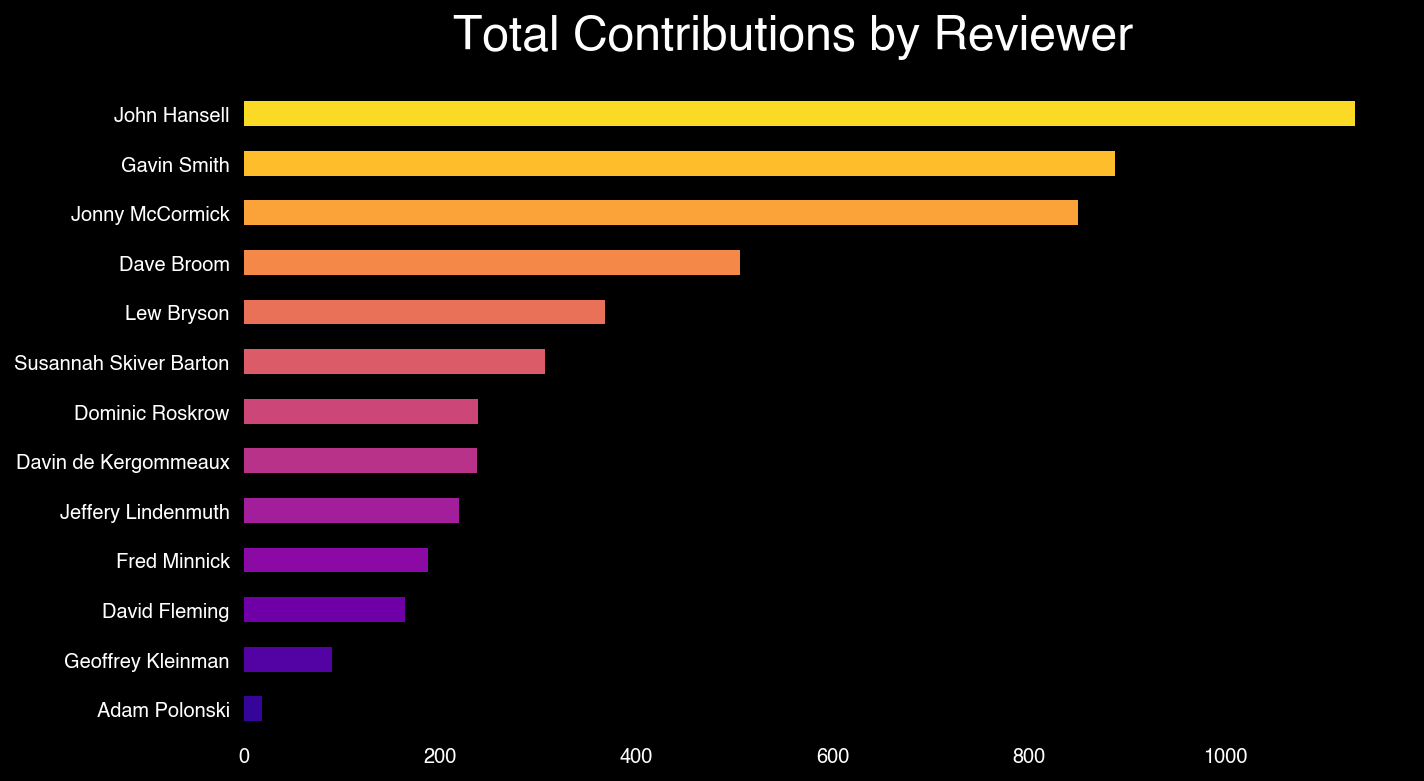

In [12]:
# reviews per reviewer
reviews_by_reviewer = whisky[['review','reviewer']].groupby('reviewer').count().sort_values(by='review')

fig,ax = plt.subplots(figsize=(10,5))
reviews_by_reviewer.plot(kind='barh', y='review', legend=None, 
                         color=sns.color_palette('plasma',n_colors=len(whisky.reviewer.unique())),
                         linewidth=0, ax=ax);

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False)

fig.text(0.32,1.025,"Total Contributions by Reviewer",fontsize=24)
ax.set_ylabel('')
plt.tight_layout();

<ipython-input-13-0ad4e32b8aa2>:57: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



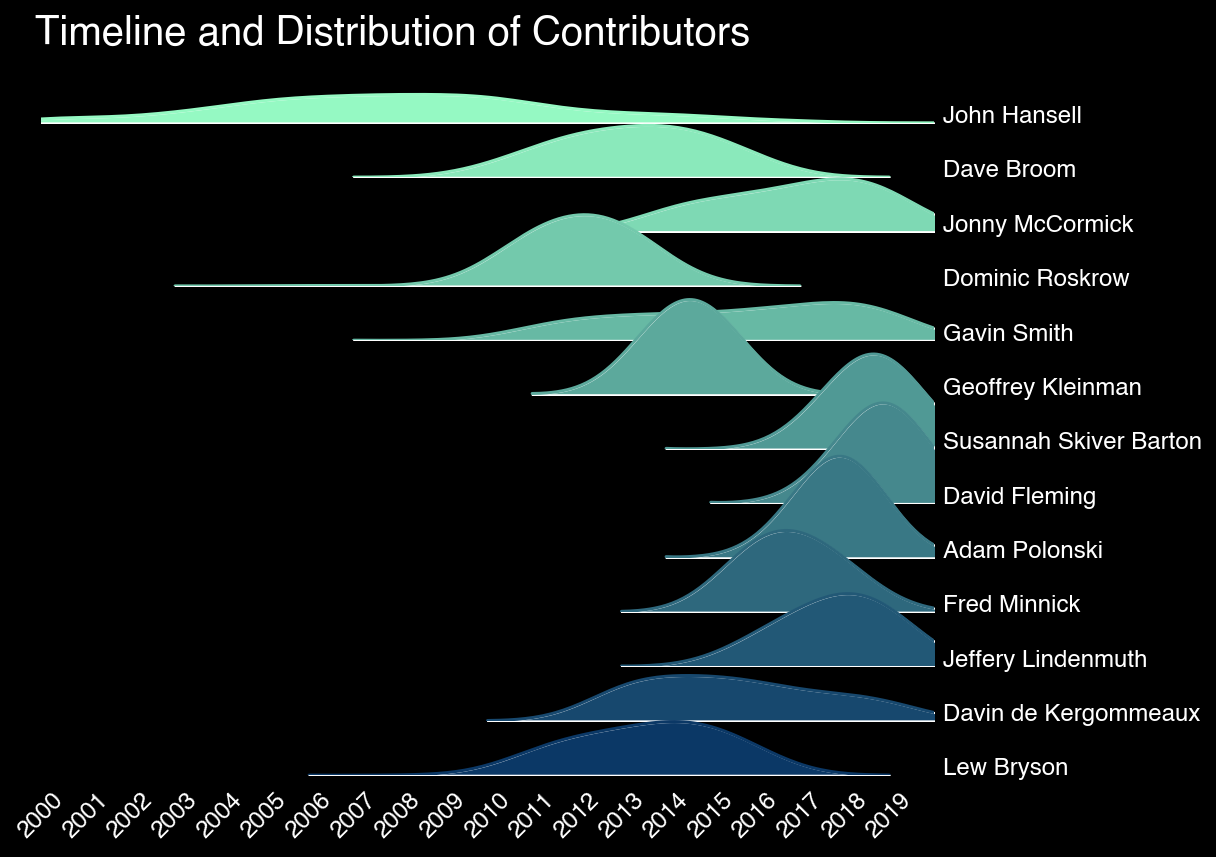

In [13]:
# Reviewer contributions over the years
reviewers = pd.Series(whisky.reviewer.unique())
colors = ['#95F9C3', '#8AE9BB','#7ED9B4','#73C9AC','#67B9A4','#5CA99C',
          '#509995','#45888D','#397885', '#2E687D','#225876',
          '#17486e','#0b3866'
         ]

gs = grid_spec.GridSpec(len(reviewers),1)
fig = plt.figure(figsize=(8,7))

i = 0

ax_objs = []
for reviewer in reviewers:
    reviewer = reviewers[i]
    x = np.array(years_filtered[years_filtered.reviewer == reviewer].year)

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    sns.kdeplot(x, bw=1, shade=True, alpha=1, color=colors[i], ax=ax_objs[-1])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(2000,2020)
    ax_objs[-1].set_ylim(0,.4)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(reviewers)-1:
        ax_objs[-1].set_xlabel("", fontsize=16,fontweight="bold")
        ax_objs[-1].set_xticks(sorted(years_filtered.year.unique()))
        ax_objs[-1].set_xticklabels([i for i in sorted(years_filtered.year.unique())], 
                                    fontsize=12, rotation=45)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    #adj_reviewers = reviewer.replace(" ","\n")
    ax_objs[-1].text(2020.2,0,reviewers[i],fontsize=12,ha="left")


    i += 1

gs.update(hspace=-0.5)

fig.text(0.12,0.85,"Timeline and Distribution of Contributors",fontsize=20)

plt.tight_layout()
plt.show();

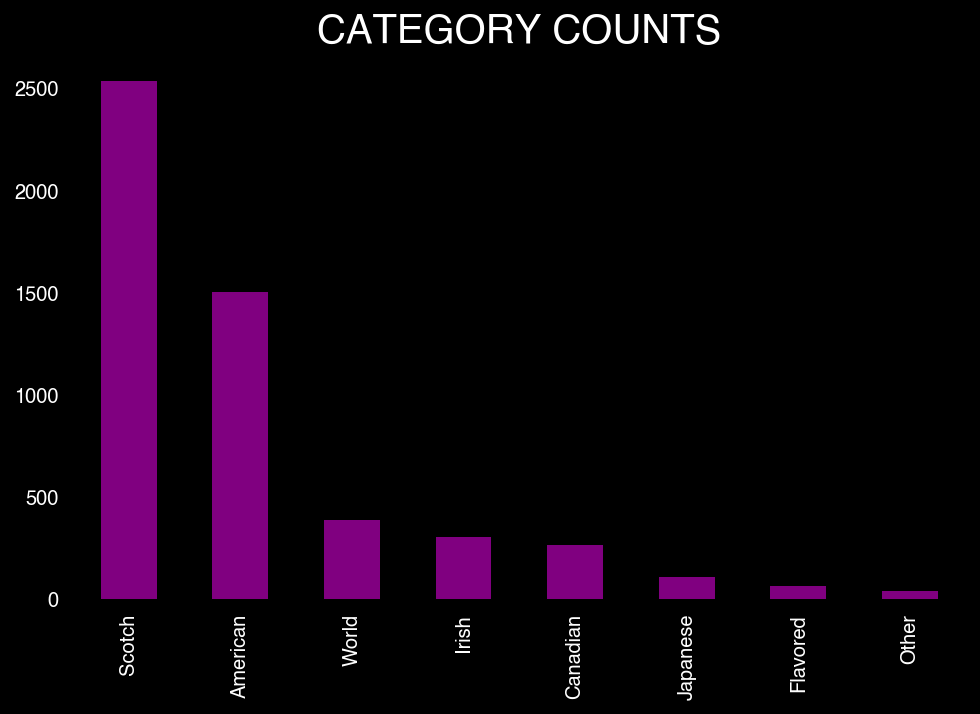

In [14]:
# Category counts
category_counts = whisky[['label','category']].groupby('category').count().sort_values(by='label',ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
category_counts.plot(kind='bar', 
                     color='purple',
                    linewidth=0, legend=False, ax=ax)

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False);

ax.set_title('CATEGORY COUNTS',fontsize=20, )
ax.set_xlabel('');

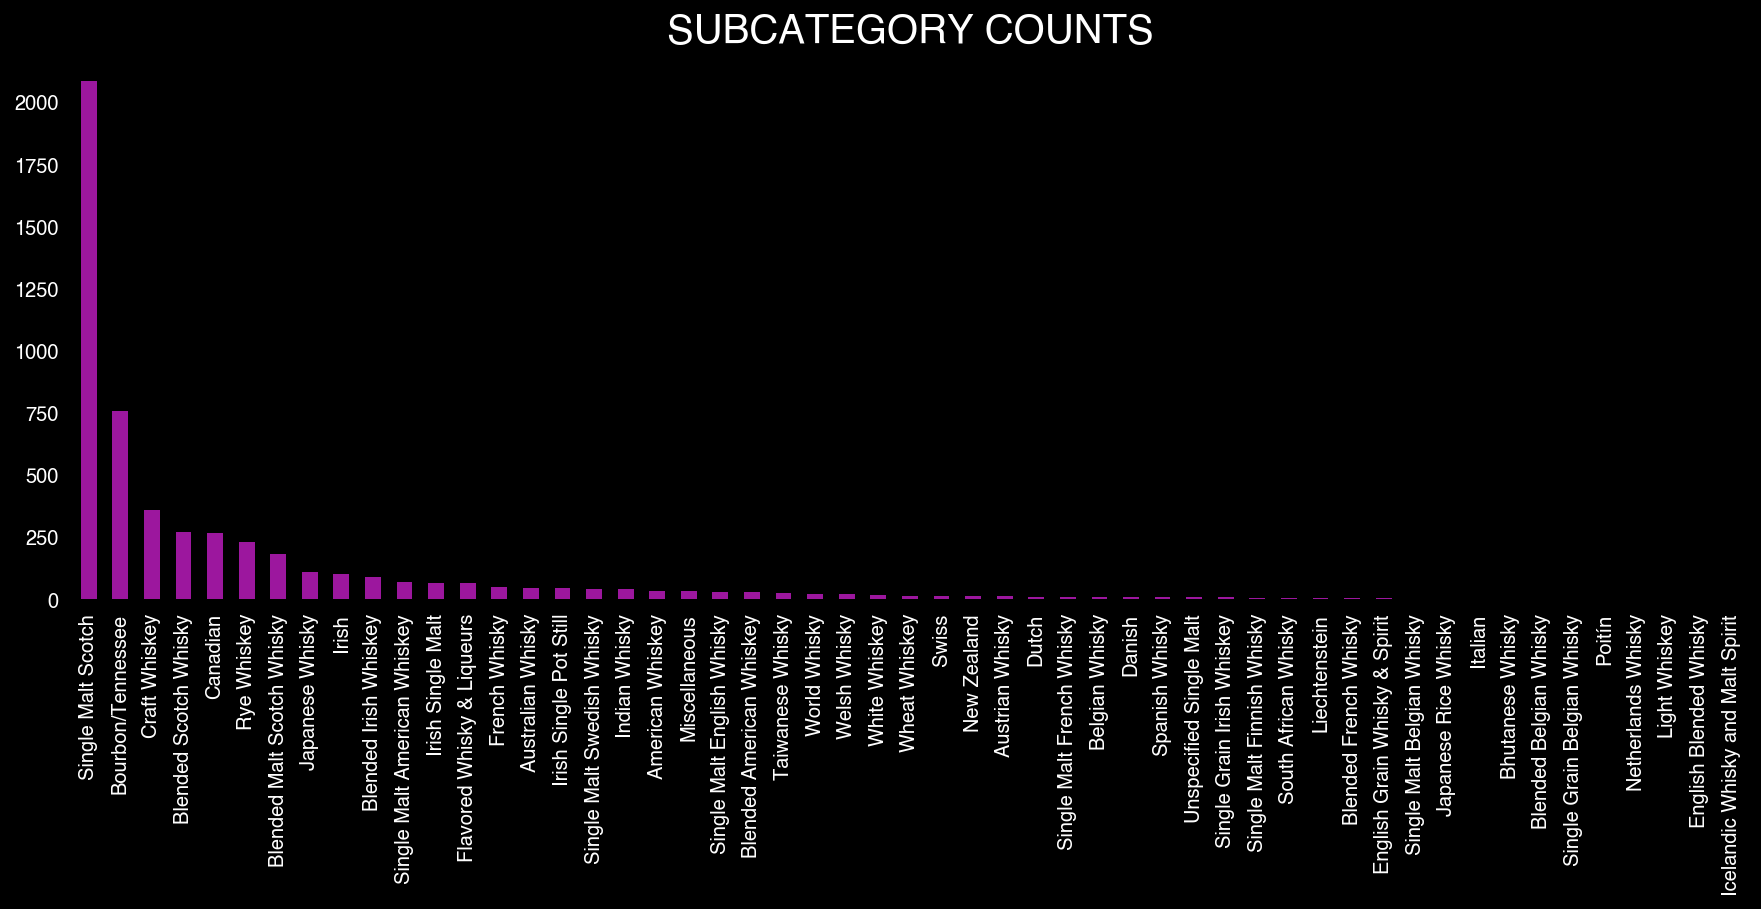

In [15]:
# Subcategory counts
category_counts = whisky[['label','subcategory']].groupby('subcategory').count().sort_values(by='label',ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
category_counts.plot(kind='bar', 
                     color=sns.color_palette('plasma',n_colors=2),
                     linewidth=0, legend=False, ax=ax)

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False);

ax.set_title('SUBCATEGORY COUNTS',fontsize=20, )
ax.set_xlabel('');

In [16]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  
0 40.50  4,500.00    42     1964  
1 42.90 13,500.00    46     1964  
2 40.00    225.00  <NA>     <NA>  
3 50.80    750.00  <NA>     1969  
4 45.40  1,500.00    29     1976

### Linear Regression

In [17]:
whisky.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5208 entries, 0 to 5207
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       5208 non-null   int64  
 1   label        5208 non-null   object 
 2   subcategory  5208 non-null   object 
 3   category     5208 non-null   object 
 4   review       5208 non-null   object 
 5   reviewer     5208 non-null   object 
 6   year         5208 non-null   Int64  
 7   abv          5182 non-null   float64
 8   price        5208 non-null   float64
 9   age          1954 non-null   Int64  
 10  vintage      1164 non-null   Int64  
dtypes: Int64(3), float64(2), int64(1), object(5)
memory usage: 503.5+ KB


In [18]:
whisky_age = whisky.copy()
whisky_age = whisky_age[['rating', 'label', 'abv','price','age']]

In [19]:
whisky_age.dropna(inplace=True)
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  1946 non-null   int64  
 1   label   1946 non-null   object 
 2   abv     1946 non-null   float64
 3   price   1946 non-null   float64
 4   age     1946 non-null   Int64  
dtypes: Int64(1), float64(2), int64(1), object(1)
memory usage: 93.1+ KB


In [20]:
whisky_age['price_winz'] = winsorize(whisky_age.price, (0,0.15))
whisky_age['age_winz'] = winsorize(whisky_age.age, (0,0.1))

In [21]:
whisky_age['age_winz']= pd.to_numeric(whisky_age.age_winz)

In [22]:
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rating      1946 non-null   int64  
 1   label       1946 non-null   object 
 2   abv         1946 non-null   float64
 3   price       1946 non-null   float64
 4   age         1946 non-null   Int64  
 5   price_winz  1946 non-null   float64
 6   age_winz    1946 non-null   int64  
dtypes: Int64(1), float64(3), int64(2), object(1)
memory usage: 123.5+ KB


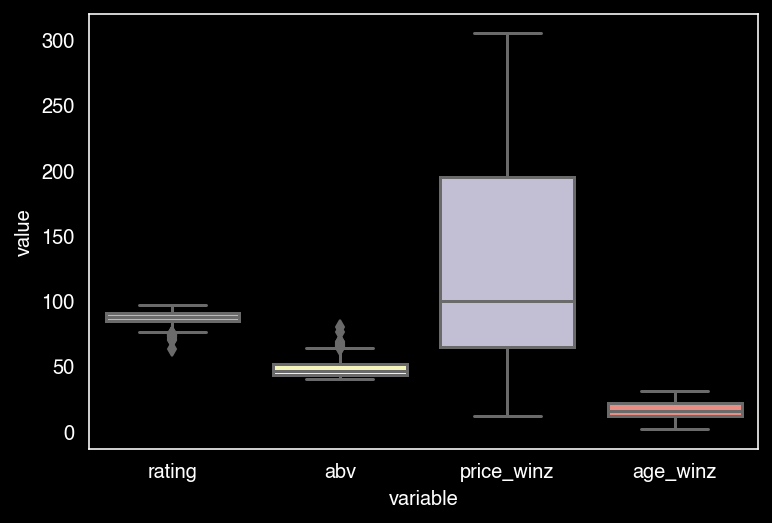

In [23]:
sns.boxplot(x='variable', y='value', data=pd.melt(whisky_age[['rating','abv','price_winz','age_winz']]))

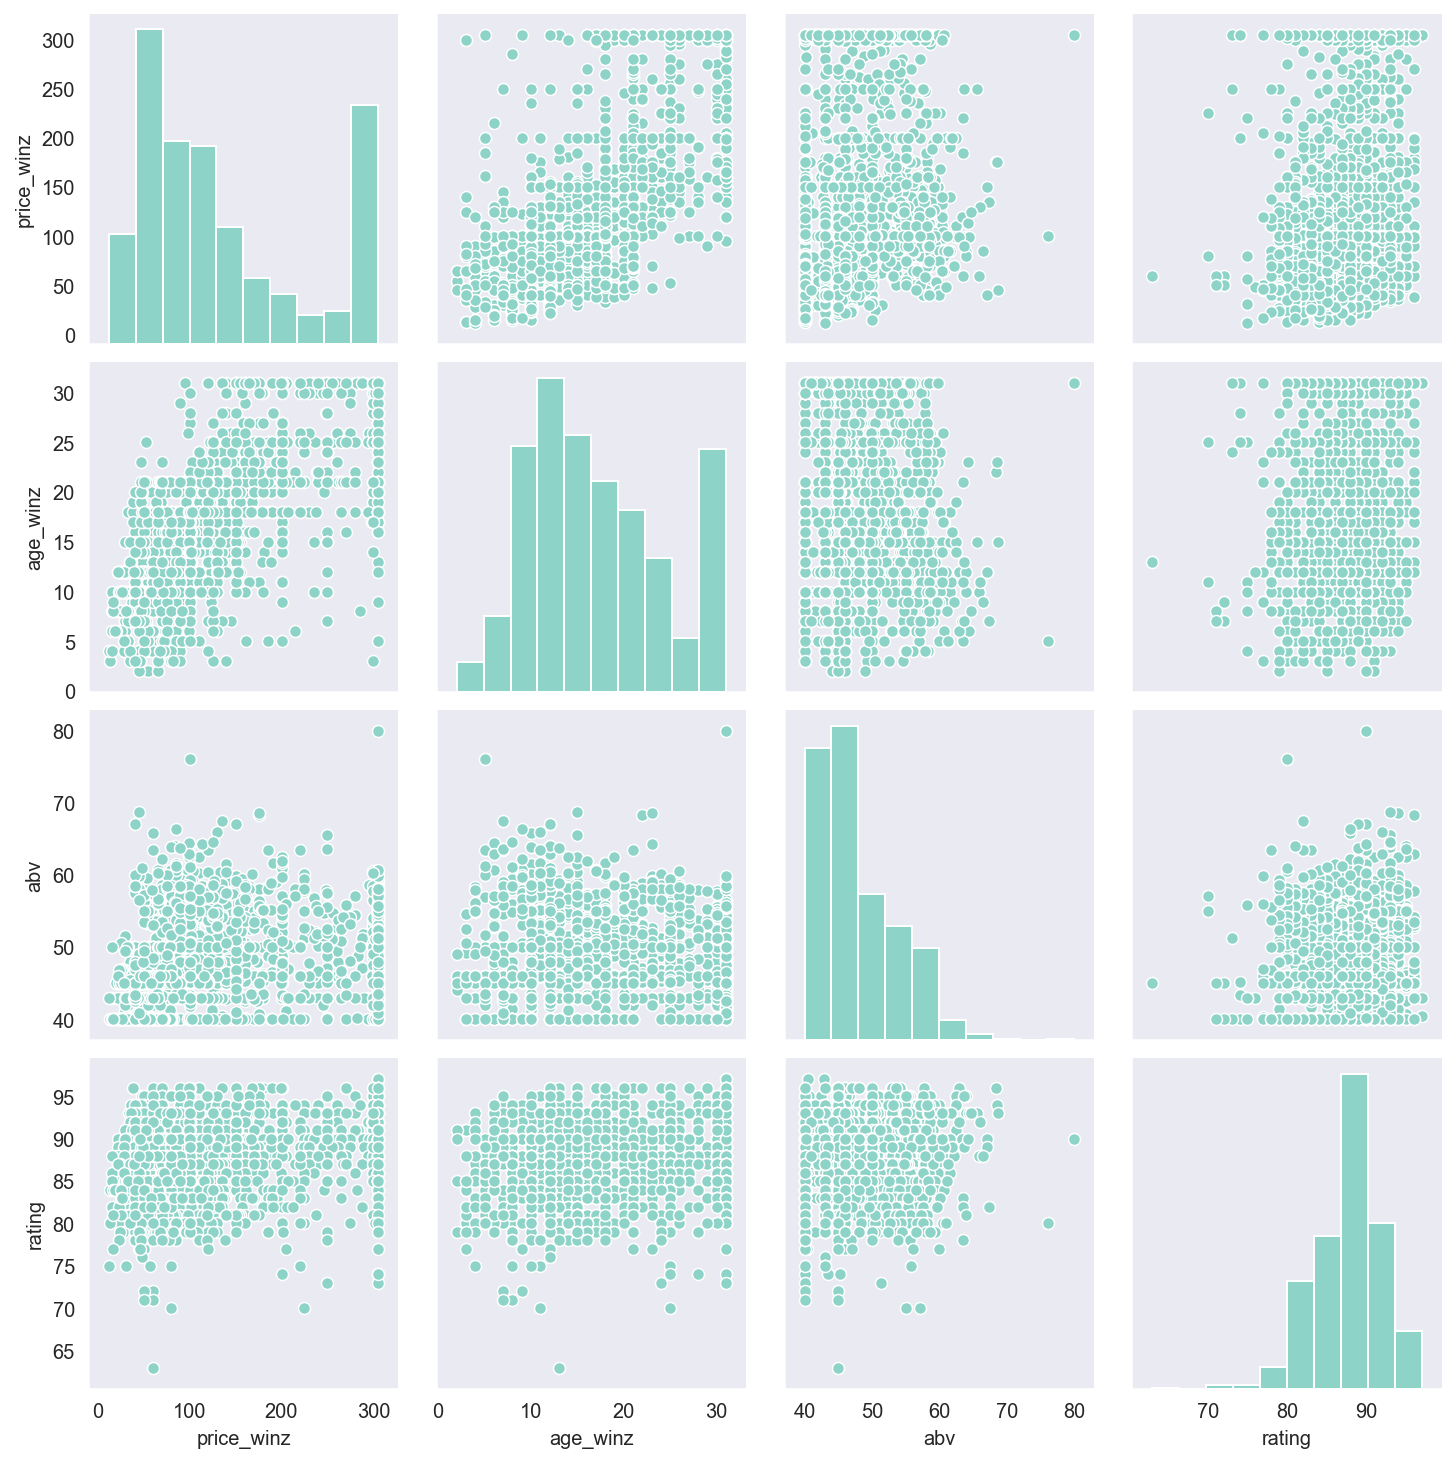

In [24]:
sns.set_style('dark')
sns.pairplot(whisky_age[['price_winz','age_winz','abv','rating']]);

In [25]:
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rating      1946 non-null   int64  
 1   label       1946 non-null   object 
 2   abv         1946 non-null   float64
 3   price       1946 non-null   float64
 4   age         1946 non-null   Int64  
 5   price_winz  1946 non-null   float64
 6   age_winz    1946 non-null   int64  
dtypes: Int64(1), float64(3), int64(2), object(1)
memory usage: 203.5+ KB


In [26]:
# linear regression between age and price
X = whisky_age[['age_winz','abv']]
y = whisky_age['price_winz']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=22)

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             price_winz   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1343.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:35:27   Log-Likelihood:                -8444.0
No. Observations:                1556   AIC:                         1.689e+04
Df Residuals:                    1553   BIC:                         1.691e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -164.7945     11.625    -14.176      0.0

Here we see that age and abv do have an affect on price. (Rating was not included since it is given to the whisky after it is already brought to the market, therefore it would not have an affect on price)

For every year the whisky stays in the barrel, the price for whisky increases by \$9.40

For every percent increase of ABV, the price increases by \$2.89

The constant even tells an interesting story. If the age of the corn liquour and the ABV are both 0, then the price would be -\$164.79. And I don't know about you, but you couldn't pay me to drink non-alcoholic corn liqour that's been quickly passed through a barrell.

In [27]:
X = whisky_age[['age_winz','abv','price']]
y = whisky_age['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=22)

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     30.78
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           2.52e-19
Time:                        11:35:27   Log-Likelihood:                -4426.0
No. Observations:                1556   AIC:                             8860.
Df Residuals:                    1552   BIC:                             8881.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.3477      0.879     93.656      0.0

Here we can see that while there are siginificant findings with age and abv, they have very little affect on the rating of the whisky (as should be the case since the rating should be based on taste alone). 

# NLP
---

In [197]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  \
0 40.50  4,500.00    42     1964   
1 42.90 13,500.00    46     1964   
2 40.00    225.00  <NA>     <NA>   
3 50.80    750.00  <NA>     1969   
4 45.40  1,500.00    29     1976   

                                    text_for_unigram  \
0  What impresses me most is how this whisky evol...   
1  There have been some legendary Bowmores from t...   
2  Magnificently powerful and intense. Caramels, ...   
3  It’s great that Glenlivet releases whiskies un...   
4  Classic sherry cask-aged Macallan. Antique amb...   

                                     text_for_bigram  
0  Black Bowmore 42 year old 1964 vintage, 40.5% ...  
1  Bowmore 46 year old (distilled 1964), 42.9% Th...  
2  Johnnie Walker Blue Label, 40% Magnificently p...  
3  Glenlivet Cellar Collection 1969 vintage, 50.8...  
4  The Macallan 29 year old 1976 Vintage (Cask #1...

In [198]:
# Creating a variable with all of the relevant words regarding each whisky
whisky['text_for_unigram'] = whisky['review']
whisky['text_for_bigram'] = whisky['label'] + " " + whisky['review'] + " " + whisky['category'] + " " + whisky['subcategory']

In [199]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  \
0 40.50  4,500.00    42     1964   
1 42.90 13,500.00    46     1964   
2 40.00    225.00  <NA>     <NA>   
3 50.80    750.00  <NA>     1969   
4 45.40  1,500.00    29     1976   

                                    text_for_unigram  \
0  What impresses me most is how this whisky evol...   
1  There have been some legendary Bowmores from t...   
2  Magnificently powerful and intense. Caramels, ...   
3  It’s great that Glenlivet releases whiskies un...   
4  Classic sherry cask-aged Macallan. Antique amb...   

                                     text_for_bigram  
0  Black Bowmore 42 year old 1964 vintage, 40.5% ...  
1  Bowmore 46 year old (distilled 1964), 42.9% Th...  
2  Johnnie Walker Blue Label, 40% Magnificently p...  
3  Glenlivet Cellar Collection 1969 vintage, 50.8...  
4  The Macallan 29 year old 1976 Vintage (Cask #1...

In [200]:
# NLP processing, stemming
# creating a list of extra stop words to filter out and help differentiate the articles
whisky_words = ['whisky','whiskey','whiski','notes','note','nose','palat','palate','finish','flavor']

In [201]:
stop_words = stopwords.words('english')
stop_words.extend(whisky_words)
stemmer = SnowballStemmer("english")

In [202]:
TAGS = re.compile('<.*?>')
PUNCT = re.compile("([.;:!\'?\"()\[\]])|(\-)|(\/)|(\\n)|(\\r)|(\*)")
COMMA = re.compile('([,])')
CUSTOM_STOPS = re.compile(r"\b(" + "|".join(whisky_words) + ")\\W*", re.I)

In [203]:
def formatting(body):
    body = body.lower()
    body = TAGS.sub(' ', body)
    body = PUNCT.sub(' ', body)
    body = COMMA.sub('', body)
    body = CUSTOM_STOPS.sub('', body)
    return body

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


# Tried word_tokenize - also removed numbers
# Tokenize and lemmatize
def bigram_preprocess(text):
    result=[]
    for token in word_tokenize(text): # doesn't remove numbers
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 1:
            result.append(lemmatize_stemming(token))         
    return ' '.join(result)

def unigram_preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) : #removes numbers too
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3:
            result.append(lemmatize_stemming(token))         
    return ' '.join(result)

In [204]:
test = whisky.text_for_unigram[3]
test

"It’s great that Glenlivet releases whiskies under the 'Cellar Collection' label. It really shows the true potential of Glenlivet. This bottling is classic ultra-matured Glenlivet, and rivals the 1959 vintage Cellar Collection as the best one ever. An incredibly complex whisky, with notes of vanilla, ripe barley, coconut, and caramel. All this is accentuated by glazed orange, hazelnut, and a potpourri of dried spices. Not the least bit tired for such an aged whisky. (Only 800 bottles for the U.S.)"

In [205]:
test = formatting(test)
test

'it’s great that glenlivet releases es under the  cellar collection  label  it really shows the true potential of glenlivet  this bottling is classic ultra matured glenlivet and rivals the 1959 vintage cellar collection as the best one ever  an incredibly complex with of vanilla ripe barley coconut and caramel  all this is accentuated by glazed orange hazelnut and a potpourri of dried spices  not the least bit tired for such an aged only 800 bottles for the u s  '

In [206]:
test = bigram_preprocess(test)
test

'great glenlivet releas es cellar collect label show true potenti glenlivet bottl classic ultra matur glenlivet rival 1959 vintag cellar collect best incred complex vanilla ripe barley coconut caramel accentu glaze orang hazelnut potpourri dri spice bite tire age 800 bottl'

In [207]:
test = unigram_preprocess(test)
test

'great glenlivet relea cellar collect label true potenti glenlivet bottl classic ultra matur glenlivet rival vintag cellar collect best incr complex vanilla ripe barley coconut caramel accentu glaze orang hazelnut potpourri dri spice bite tire age bottl'

In [208]:
whisky['text_for_unigram'] = whisky.text_for_unigram.apply(formatting)
whisky['text_for_unigram'] = whisky.text_for_unigram.apply(unigram_preprocess)

whisky['text_for_bigram'] = whisky.text_for_bigram.apply(formatting)
whisky['text_for_bigram'] = whisky.text_for_bigram.apply(bigram_preprocess)


In [209]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  \
0 40.50  4,500.00    42     1964   
1 42.90 13,500.00    46     1964   
2 40.00    225.00  <NA>     <NA>   
3 50.80    750.00  <NA>     1969   
4 45.40  1,500.00    29     1976   

                                    text_for_unigram  \
0  impress evolv incred complex viscous sticki to...   
1  legendari bowmor mid bite equal share remark a...   
2  magnific power intens caramel dri peat eleg ci...   
3  great glenlivet releas cellar collect label sh...   
4  classic sherri cask age macallan antiqu amber ...   

                                     text_for_bigram  
0  black bowmor 42 year old 1964 vintag 40 impres...  
1  bowmor 46 year old distil 1964 42 legendari bo...  
2  johnni walker blue label 40 magnific power int...  
3  glenlivet cellar collect 1969 vintag 50 great ...  
4  macallan 29 year old 1976 vintag cask 11354 45...

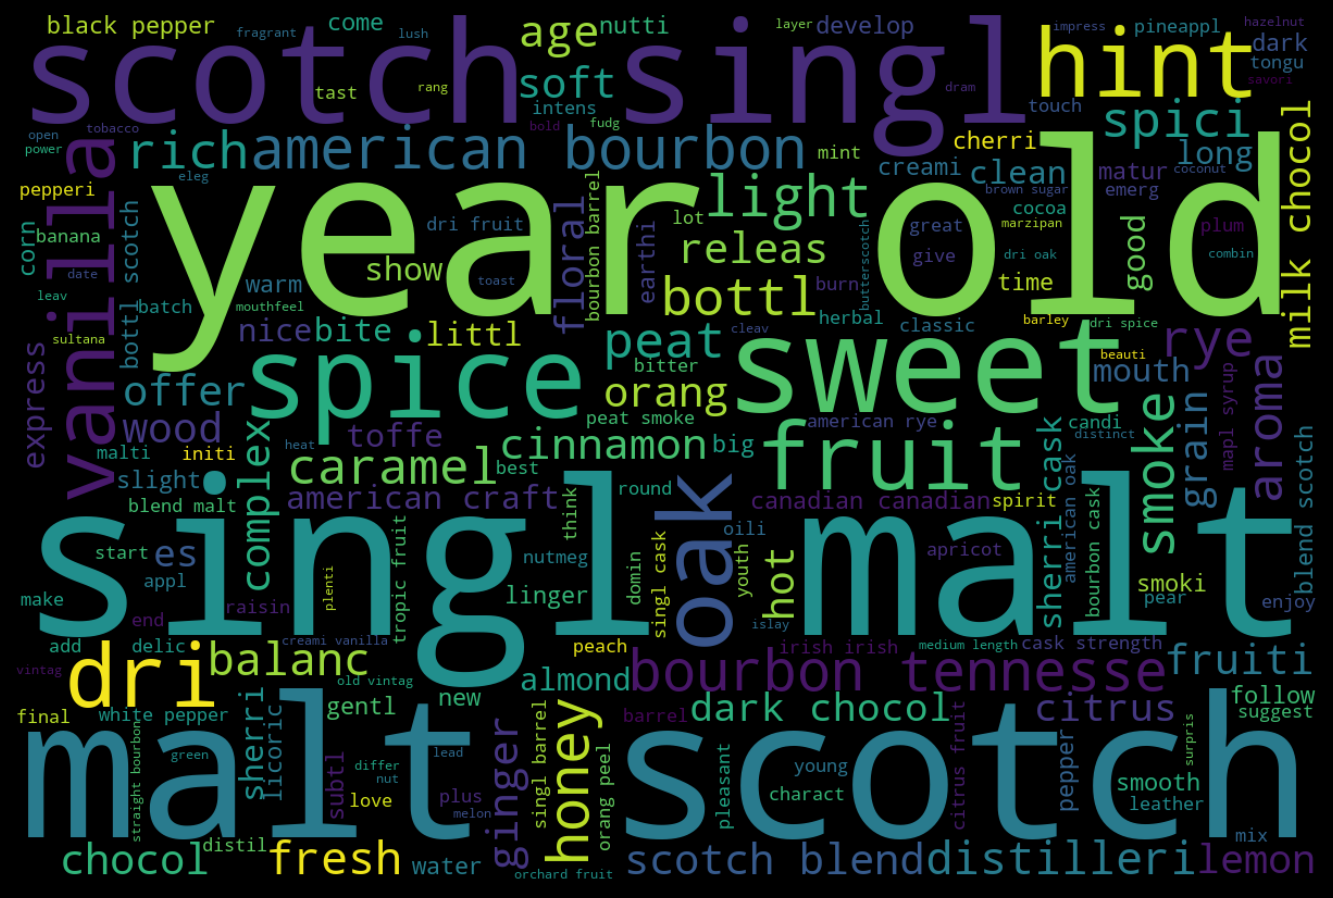

In [210]:
# word cloud
stopwords = set(STOPWORDS)
stopwords.update(["drink", "whiskey",'whisky','whiskey','whiski','notes','note','nose','palat','palate','finish','flavor'])

text = " ".join(review for review in whisky.text_for_bigram)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords).generate(text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Important words to note:
* singl malt
* malt scotch
* Sweet
* oak
* spice
* year old
* cinnamon
* honey
* malt
* smoke
* caramel
* vanilla
* fruit
* ginger


In [211]:
# Bottom and top 10% of ratings
top10pct = whisky[['rating','text_for_bigram']].sort_values(by='rating', axis=0, ascending=False).iloc[:500]
bottom10pct = whisky[['rating','text_for_bigram']].sort_values(by='rating', axis=0, ascending=True).iloc[:500]

In [212]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(top10pct.text_for_bigram)

top_top_words = pd.DataFrame(np.asarray(cv_fit.sum(axis=0)), columns=cv.get_feature_names())

In [213]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(top10pct.text_for_bigram)

top_top10_words = pd.DataFrame(np.asarray(cv_fit.sum(axis=0)), columns=cv.get_feature_names()).T

top = top_top10_words.sort_values(by=0, axis=0, ascending=False).iloc[:20]

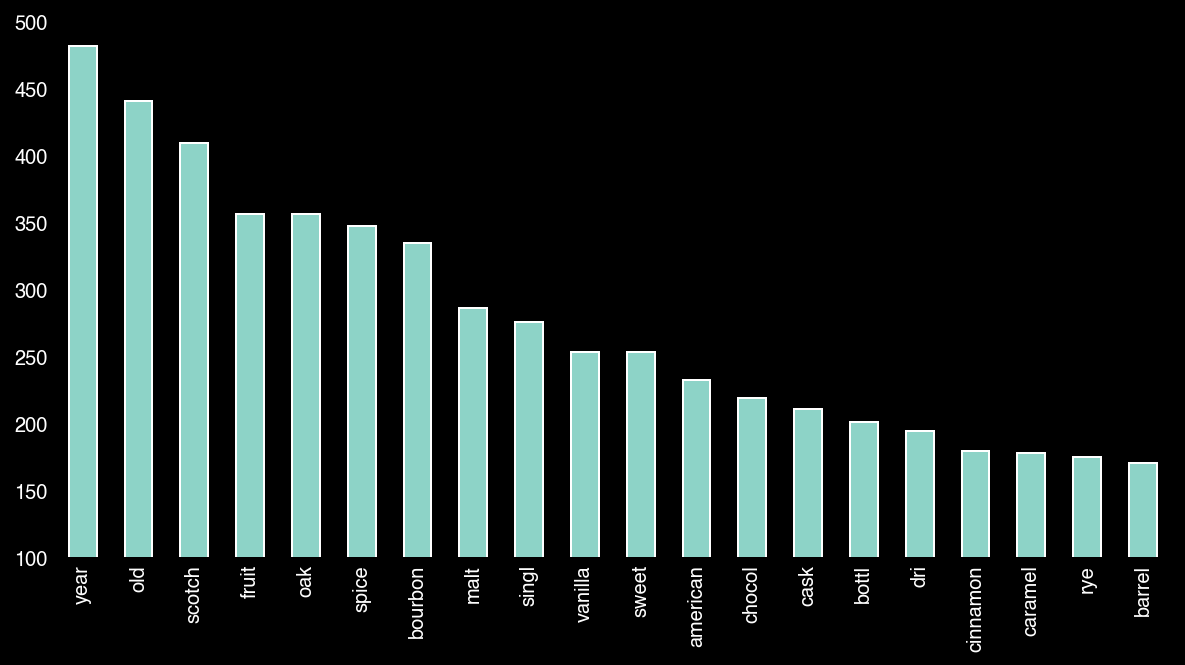

In [214]:
fig, ax = plt.subplots(figsize=(10,5))
top.plot(kind='bar', legend=False, ax=ax)
plt.ylim(100,);

In [215]:
cv_fit=cv.fit_transform(bottom10pct.text_for_bigram)

top_bottom10_words = pd.DataFrame(np.asarray(cv_fit.sum(axis=0)), columns=cv.get_feature_names()).T

bottom = top_bottom10_words.sort_values(by=0, axis=0, ascending=False).iloc[:20]

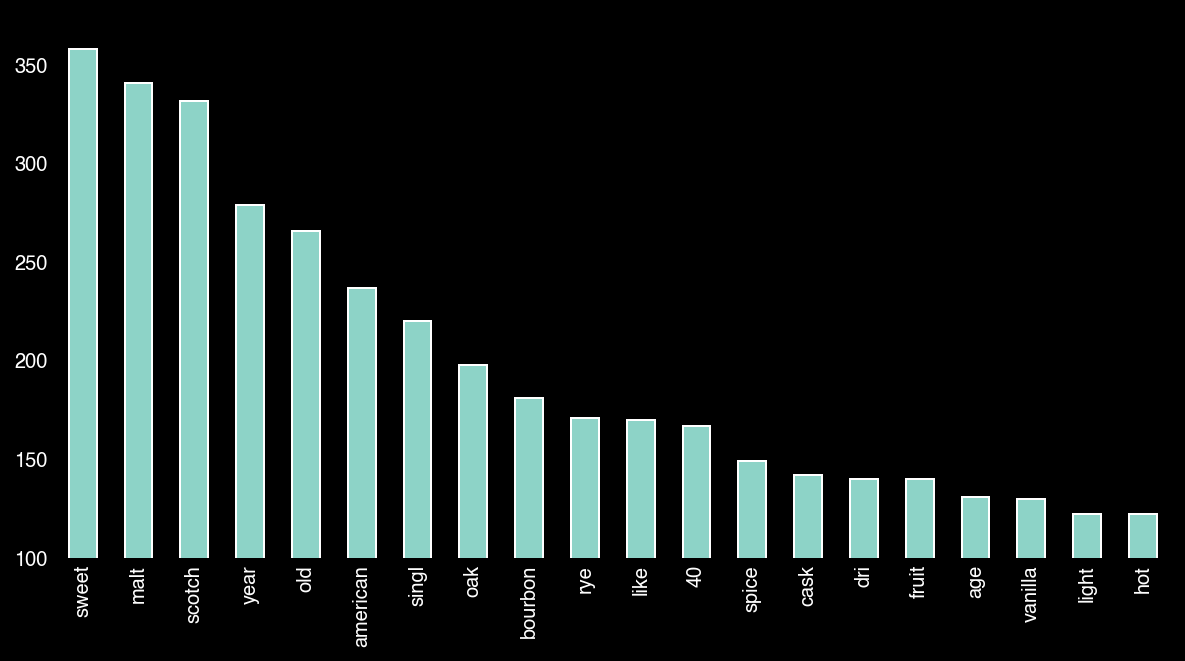

In [216]:
fig, ax = plt.subplots(figsize=(10,5))
bottom.plot(kind='bar', legend=False, ax=ax)
plt.ylim(100,);

## Vectorization
___

In [217]:
# Bigram TFIDF
bigram_vec = TfidfVectorizer(stop_words=stop_words, max_df=.7, 
                               min_df=.01, ngram_range=(2,2), max_features=3000)

# fit / transform
bigram_fitted_vectorizer=bigram_vec.fit(whisky.text_for_bigram)
bigram_tfidf_vectors=bigram_fitted_vectorizer.transform(whisky.text_for_bigram)

# to data frame with words as columns
bigram_tfidf = pd.DataFrame(bigram_tfidf_vectors.toarray(), columns=bigram_vec.get_feature_names())

bigram_tfidf.head()

10 year  11 year  12 year  13 year  14 year  15 year  16 year  17 year  \
0     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
1     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
2     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
3     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
4     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   

   18 year  20 year  ...  vanilla cream  vanilla fudg  vanilla honey  \
0     0.00     0.00  ...           0.00          0.00           0.00   
1     0.00     0.00  ...           0.00          0.00           0.00   
2     0.00     0.00  ...           0.00          0.00           0.00   
3     0.00     0.00  ...           0.00          0.00           0.00   
4     0.00     0.00  ...           0.00          0.00           0.00   

   water bring  wemyss malt  white pepper  wine cask  wood spice  world singl  \
0         0.00         0.00          0.00       0.00        0.00         0.00   
1         0.00         0.00          0.00       0.00        0.00         0.00   
2         0.00         0.00          0.00       0.00        0.00         0.00   
3         0.00         0.00          0.00       0.00        0.00         0.00   
4         0.00         0.00          0.00       0.00        0.00         0.00   

   year old  
0      0.16  
1      0.26  
2      0.00  
3      0.00  
4      0.21  

[5 rows x 189 columns]

In [218]:
# Unigram TFIDF
unigram_vec = TfidfVectorizer(stop_words=stop_words, max_df=.7, 
                                min_df=.01, ngram_range=(1,1), max_features=3000)

# fit / transform
unigram_fitted_vectorizer=unigram_vec.fit(whisky.text_for_unigram)
unigram_tfidf_vectors=unigram_fitted_vectorizer.transform(whisky.text_for_unigram)

# to data frame with words as columns
unigram_tfidf = pd.DataFrame(unigram_tfidf_vectors.toarray(), columns=unigram_vec.get_feature_names())

unigram_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  work  world  wrap  year  yield  young  younger  youth  zest  zesti  
0  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
1  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
2  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
3  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
4  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  

[5 rows x 645 columns]

In [219]:
# Join TFIDFS together
whisky_tfidf = unigram_tfidf.join(bigram_tfidf)
whisky_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  vanilla cream  vanilla fudg  vanilla honey  water bring  wemyss malt  \
0  ...           0.00          0.00           0.00         0.00         0.00   
1  ...           0.00          0.00           0.00         0.00         0.00   
2  ...           0.00          0.00           0.00         0.00         0.00   
3  ...           0.00          0.00           0.00         0.00         0.00   
4  ...           0.00          0.00           0.00         0.00         0.00   

   white pepper  wine cask  wood spice  world singl  year old  
0          0.00       0.00        0.00         0.00      0.16  
1          0.00       0.00        0.00         0.00      0.26  
2          0.00       0.00        0.00         0.00      0.00  
3          0.00       0.00        0.00         0.00      0.00  
4          0.00       0.00        0.00         0.00      0.21  

[5 rows x 834 columns]

In [220]:
top_tens=[]
for i in range(whisky_tfidf.shape[0]):
    row = whisky_tfidf.iloc[i]
    top_tens.append(" ".join(list(row[row>0].sort_values(ascending=False)[:10].index)))

whisky_tfidf['tfidf_top_tens'] = pd.Series(top_tens)

In [221]:
whisky_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  vanilla fudg  vanilla honey  water bring  wemyss malt  white pepper  \
0  ...          0.00           0.00         0.00         0.00          0.00   
1  ...          0.00           0.00         0.00         0.00          0.00   
2  ...          0.00           0.00         0.00         0.00          0.00   
3  ...          0.00           0.00         0.00         0.00          0.00   
4  ...          0.00           0.00         0.00         0.00          0.00   

   wine cask  wood spice  world singl  year old  \
0       0.00        0.00         0.00      0.16   
1       0.00        0.00         0.00      0.26   
2       0.00        0.00         0.00      0.00   
3       0.00        0.00         0.00      0.00   
4       0.00        0.00         0.00      0.21   

                                      tfidf_top_tens  
0  black cherri chocol cover polish leather roast...  
1  peat smoke tropic fruit editor choic scotch si...  
2  dri spice blend scotch scotch blend seed smoke...  
3  dri spice bottl scotch collect scotch singl ma...  
4  spice cinnamon dri spice sherri cask wisp anti...  

[5 rows x 835 columns]

## Decomposition
---

In [222]:
X = whisky_tfidf.iloc[:,:-1]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#### PCA

In [298]:
# PCA 3D
pca = PCA(n_components=3, whiten=True, random_state=22).fit_transform(X)

fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        #color=whisky.category, 
        #colorscale='viridis',
    ),
    
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    

)])

# tight layout
fig.update_layout(height=400,
                  title_text='PCA',
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      )
                           ),
                  dragmode='orbit'
                 )

fig.show()

#### UMAP

In [301]:
# UMAP visual for X Standardized and predicted LDA overlay
umap_results = umap.UMAP(n_neighbors=10, min_dist=0.01, metric='hellinger', 
                         n_components=3, random_state=22).fit_transform(X)

In [302]:
fig = go.Figure(data=[go.Scatter3d(
            x=umap_results[:,0],
            y=umap_results[:,1],
            z=umap_results[:,2],
            mode='markers',
            marker=dict(
                size=3,
                #color=covid_lda.prob_topic, 
                #colorscale='viridis',
            ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
        )])

fig.update_layout(height=500,
                  width=500,
                  title_text='UMAP with LDA Topic Overlay',
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      )
                           ),
                  dragmode='orbit'
                 )
fig.show()

## Unsupervised Learning
___

#### Hierarchical

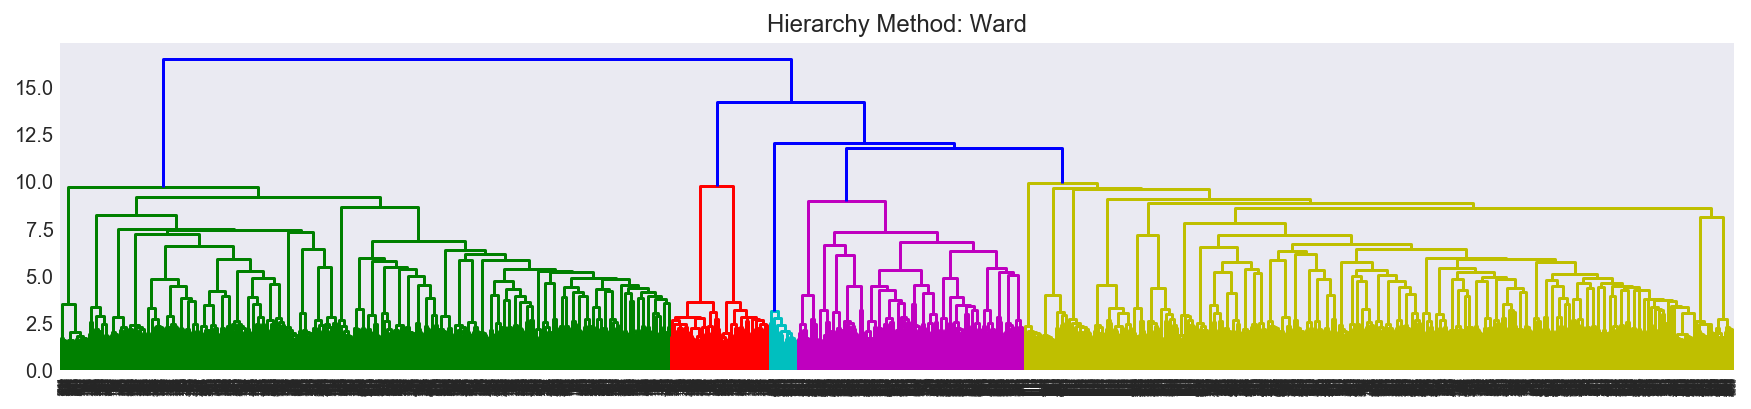

In [226]:
# Hierarchical with X
methods = ['average', 'complete', 'ward'] #all were run, ward looks the best

plt.style.use('seaborn-dark')
plt.figure(figsize=(15,3))
dendrogram(linkage(X, method='ward'))
plt.title(f'Hierarchy Method: Ward')
plt.xticks(fontsize=4)
plt.show()


In [300]:
# heirarchical 
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') 
# only euclidean is accepted
hier_clusters = cluster.fit_predict(X)


fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster.labels_, 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='Hierarchical Clustering with PCA <br>Clusters - Colors</br>',
                  height=600, 
                  width=800,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

In [303]:
# UMAP with Hierarchical Colors
fig = go.Figure(data=[go.Scatter3d(
    x=umap_results[:,0],
    y=umap_results[:,1],
    z=umap_results[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster.labels_, 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='Hierarchical Clustering with UMAP <br>Clusters - Colors</br>',
                  height=600, 
                  width=800,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

## Modeling
---

In [290]:
X = whisky_tfidf.iloc[:,:-1]
Y = whisky['label']

rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=22)

rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

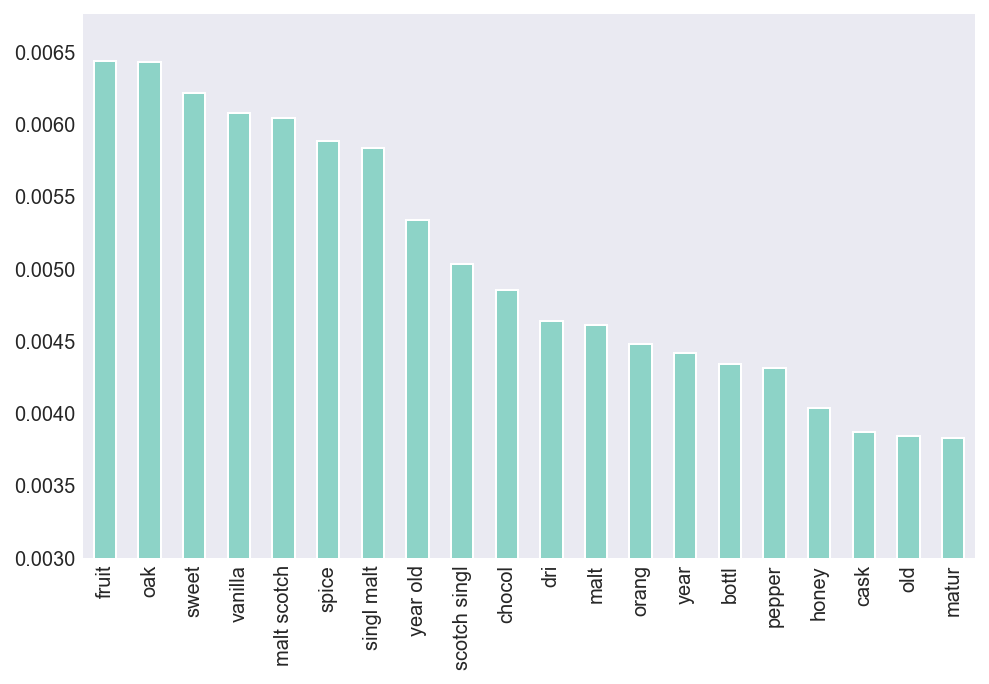

In [297]:
rfc_feat_import = pd.DataFrame(rfc.feature_importances_, index=X.columns).sort_values(by=0, axis=0, ascending=False)[:20]
fig, ax = plt.subplots(figsize=(8,5))
rfc_feat_import.plot(kind='bar', legend=False, ax=ax)
plt.ylim(.003,);

In [235]:
test_input = 'bourbon with notes toffee caramel'

test_input = formatting(test_input)
test_input1 = [unigram_preprocess(test_input)]
test_input2 = [bigram_preprocess(test_input)]

print(test_input)
print(test_input1)
print(test_input2)

bourbon with toffee caramel
['bourbon toffe caramel']
['bourbon toffe caramel']


In [236]:
test_unigram = unigram_vec.transform(test_input1).toarray()
test_bigram = bigram_vec.transform(test_input2).toarray()

In [237]:
full_test = np.concatenate([test_unigram, test_bigram], axis=1)

In [239]:
probas = rfc.predict_proba(full_test)
top_probas = pd.DataFrame(probas, columns=rfc.classes_).T
top_3_list = top_probas.sort_values(by=0, axis=0, ascending=False)[:3]
top_3_list

0
Wild Turkey Tribute 15 year old, 50.5% 0.15
The Arran Malt Limited Edition, 58.4%  0.15
Berentzen Bushel & Barrel, 30%         0.10

In [240]:
prediction = rfc.predict(full_test)
prediction_string = ' '.join(prediction)

In [260]:
for i in top_3_list.index:

    THE_WHISKY = whisky[whisky.label == str(i)]

    print(' '.join(THE_WHISKY.label.values))
    print('Rating: ' + str(int(THE_WHISKY.rating.values)))
    print(' '.join(THE_WHISKY.subcategory))
    print(' '.join(THE_WHISKY.review))
    print('Price: $' + str(int(THE_WHISKY['price'].values)))
    print('-' * 50 + '\n')

Wild Turkey Tribute 15 year old, 50.5%
Rating: 94
Bourbon/Tennessee
A special bottling of Wild Turkey to celebrate Master Distiller Jimmy Russell’s 50 years of being in the bourbon business. Jimmy will be proud to be associated with this bottling. In many ways, this bourbon is a lot like Jimmy: mature, yet with plenty of spunk and character, and a pure joy to be with. This is a big, chewy, full-bodied bourbon with lovely sweet notes (maple syrup, molasses, caramel and candied fruit) balanced by dry spice notes (cigars aged in cedar, evergreen, polished leather). For bourbon drinkers who love intensity in their bourbon. 

Price: $90
--------------------------------------------------

The Arran Malt Limited Edition, 58.4%
Rating: 80
Single Malt Scotch
Reddish amber color. Aromas of honey drenched fruit, toffee, and fudge. Medium to heavy in body. Rich and sweet in flavor (toffee, fudge, caramel), with interwoven notes of rich, ripe fruit. Lingering toffee sweetness on the finish. 

Price

### Filtering the database for multiple random forests

In [304]:
whisky.category.unique()

array(['Scotch', 'Irish', 'American', 'Canadian', 'Japanese', 'World',
       'Flavored', 'Other'], dtype=object)

In [ ]:
scotch_df
bourbon_df
rye_df
irish_df
international_df

## Word2Vec
---

### Word2Vec as a predictor

In [261]:
# Separating the reviews to create embeddings per review
sentences = [row.split(',') for row in whisky.text_for_bigram]

In [263]:
sentences[:5]

[['black bowmor 42 year old 1964 vintag 40 impress evolv incred complex viscous sticki toffe earthi oak fig cake roast nut fall fruit pancak batter black cherri ripe peach dark chocol cover espresso bean polish leather tobacco hint wild game linger leafi damp kiln smoke continu long swallow hope dream older scotch singl malt scotch'],
 ['bowmor 46 year old distil 1964 42 legendari bowmor mid 60s bite equal share remark aroma tropic fruit move hallucinatori intens guava mango peach pineappl grapefruit light touch peat smoke memori islay realiti concentr low strength silki headi haunt last forev dri glass legend bear bottl editor choic scotch singl malt scotch'],
 ['johnni walker blue label 40 magnific power intens caramel dri peat eleg cigar smoke seed scrap vanilla bean brand new pencil peppercorn coriand seed star anis deepli satisfi nose experi silki caramel bounti fruit ripe peach stew appl orang pith pervas smoke element burn tobacco abid smoke dri spice banoffe pie sweet close per

In [264]:
model = Word2Vec(sentences, size=1000, window=5, min_count=1)
X = model[model.wv.vocab]

<ipython-input-264-bb1ec065defc>:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [265]:
user_sentence = 'single malt scotch whisky oaky amber'
formatting(user_sentence)

process_sentence = bigram_preprocess(user_sentence)

process_sentence

'singl malt scotch whiski oaki amber'

In [266]:
model.build_vocab([[process_sentence]], update=True)

In [267]:
choices = model.wv.similar_by_vector(model.wv.__getitem__(process_sentence))[1:4]

In [268]:
choices

[('writer tear cask strength 2018 53 stun effort honey sunflow seed zest orang toast flapjack nectarin kiwi lime citrus open water superb delici drinkabl cask strength show honey citrus sweet toffe vanilla pod spice blast pepper soft flow fruiti envelop grind ginger cleav peppercorn fresh ginger epic 5175 bottl irish blend irish',
  0.13343478739261627),
 ('benriach 20 year old 46 rich textur complex unpeat express base honey malt creami vanilla complement citrus fruit lemon tangerin coconut bitter chocol exot wood shave hint assort nut polish oak scotch singl malt scotch',
  0.12346047163009644),
 ('tomatin 12 year old 43 pleasant sweet good malt foundat abund bright summer fruit clean straight forward uncompl scotch singl malt scotch',
  0.10854530334472656)]

In [281]:
for i in range(len(choices)):
    W2V_WHISKY = whisky[whisky.text_for_bigram == choices[i][0]]

    print(' '.join(W2V_WHISKY.label.values))
    print('Rating: ' + str(int(THE_WHISKY.rating.values)))
    print(' '.join(W2V_WHISKY.subcategory))
    print(' '.join(W2V_WHISKY.review))
    print('Price: $' + str(int(W2V_WHISKY['price'].values)))
    print('-' * 50 + '\n')

Writers’ Tears Cask Strength 2018, 53%
Rating: 86
Blended Irish Whiskey
A stunning effort, with honey, sunflower seeds, zested orange, toasted flapjacks, nectarine, kiwi, and lime, with the citrus opening up with water. Superb to see a delicious, drinkable cask-strength whiskey showing off its flavors this well: honey, citrus, sweet toffee, vanilla pod, and a spice blast of pepper before a soft, flowing fruitiness is enveloped by ground ginger. Clove, peppercorn, and fresh ginger make for an epic finish. (5,175 bottles)
Price: $145
--------------------------------------------------

BenRiach 20 year old, 46%
Rating: 86
Single Malt Scotch
The most richly textured and complex of the unpeated expressions. Base notes of honeyed malt and creamy vanilla are complemented by citrus fruit (lemon, tangerine), coconut, bitter chocolate, exotic wood shavings, and a hint of assorted nuts. Polished oak finish.
Price: $140
--------------------------------------------------

Tomatin 12 year old, 43%
R

As assumed in EDA, the model performs fairly on Scotch and even some subcategories of Scotch, but lacks performance in areas like Irish whiskies or Japanese whiskies

### Word2Vec as word association

In [282]:
# Using word2vec on each word instead of each review to give a user word suggestions
words = [word.split(' ') for word in whisky.text_for_unigram]
wa_model = Word2Vec(words, size=1000, window=10, min_count=1)
X = wa_model[wa_model.wv.vocab]

<ipython-input-282-b73599438010>:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [287]:
wa_model.wv.vocab

{'impress': <gensim.models.keyedvectors.Vocab at 0x137f846a0>,
 'evolv': <gensim.models.keyedvectors.Vocab at 0x13891b4c0>,
 'incred': <gensim.models.keyedvectors.Vocab at 0x12c08e5b0>,
 'complex': <gensim.models.keyedvectors.Vocab at 0x14a9143d0>,
 'viscous': <gensim.models.keyedvectors.Vocab at 0x14a9141c0>,
 'sticki': <gensim.models.keyedvectors.Vocab at 0x14a9143a0>,
 'toffe': <gensim.models.keyedvectors.Vocab at 0x14a914eb0>,
 'earthi': <gensim.models.keyedvectors.Vocab at 0x14a914a30>,
 'oak': <gensim.models.keyedvectors.Vocab at 0x14a914e50>,
 'fig': <gensim.models.keyedvectors.Vocab at 0x14a914b50>,
 'cake': <gensim.models.keyedvectors.Vocab at 0x14a914c70>,
 'roast': <gensim.models.keyedvectors.Vocab at 0x14a9146a0>,
 'nut': <gensim.models.keyedvectors.Vocab at 0x14a914910>,
 'fall': <gensim.models.keyedvectors.Vocab at 0x14a9142b0>,
 'fruit': <gensim.models.keyedvectors.Vocab at 0x14a9141f0>,
 'pancak': <gensim.models.keyedvectors.Vocab at 0x14a914700>,
 'batter': <gensim.mod

In [353]:
user_word = 'dry'
def similar_words(user_word):
    user_word = formatting(user_word)
    process_word = bigram_preprocess(user_word)
    similar_words = wa_model.wv.similar_by_vector(wa_model.wv.__getitem__(process_word))
    return similar_words[1:4]

In [354]:
similar_words(user_word)

[('nut', 0.9992913603782654),
 ('darken', 0.9991316795349121),
 ('cocoa', 0.9989223480224609)]

In [362]:
[i[0] for i in similar_words(user_word)]

['nut', 'darken', 'cocoa']

# Client Interface

In [383]:
user_string = []

def questions():
    print('Welcome to The Advisor.\nHere may you find your next grain adventure\n\nPlease choose from the following: ')
    print('\nIn your ideal whisky do you prefer:')
    sweet_or_dry = (str(input('Sweet or Dry: ')).lower())
    
    suggestion1 = print(input(f'''
    Your previous choice is closely related to these other three words:\n
    {', '.join([i[0] for i in similar_words(sweet_or_dry)])}
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    '''))
    user_string.append(sweet_or_dry)
    if suggestion1 == None:
        user_string.append('')
    else:
        user_string.append(suggestion1)
    
    
    smoke_or_fruit = input('Smoky or Fruity: ').lower()
    suggestion2 = print(input(f'''
    Your previous choice is closely related to these other three words:\n
    {', '.join([i[0] for i in similar_words(smoke_or_fruit)])}
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    '''))
    user_string.append(smoke_or_fruit)
    if suggestion2 == None:
        user_string.append('')
    else:
        user_string.append(suggestion2)
    
    
    
    toffee_or_pie = input('Toffee or Pie: ').lower()
    suggestion3 = print(input(f'''
    Your previous choice is closely related to these other three words:\n
    {', '.join([i[0] for i in similar_words(toffee_or_pie)])}
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    '''))
    user_string.append(toffee_or_pie)
    if suggestion3 == None:
        user_string.append('')
    else:
        user_string.append(suggestion3)
    
    
    user_string.append(input('Please further describe your ideal whisky in further detail: ').lower())
    print('Here is the full request we will be making our recommendations on:')
    print(' '.join(user_string))

In [381]:
questions()

Welcome to The Advisor.
Here may you find your next grain adventure

Please choose from the following: 

In your ideal whisky do you prefer:
Sweet or Dry: sweet

    Your previous choice is closely related to these other three words:

    textur, custard, clover
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    custard
custard
Smoky or Fruity: smoky

    Your previous choice is closely related to these other three words:

    kalamata, leav, heat
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    

Toffee or Pie: toffee

    Your previous choice is closely related to these other three words:

    mapl, caramel, ripe
    Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    

Please further describe your ideal whisky in further detail: bourbon from kentucky
Here is the full request we will be making our recommendations on:
sweet   smoky   toffee   bourbon from kentucky


In [ ]:
def select_rf():
    if user_string.str.contains('bourbon'):
        

In [382]:
user_string

['sweet', ' ', 'smoky', ' ', 'toffee', ' ', 'bourbon from kentucky']

In [ ]:
def __main__():
    user_string = []
    questions()
    select_rf()
    

In [ ]:
__main__()